In [373]:
import json
import pandas as pd
with open('contest_input.json', mode='r') as f:
    data = json.load(f)

In [374]:
import json
import pandas as pd
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
#Задача

In [ ]:
!pip install --upgrade --user ortools

In [375]:
couriers = pd.DataFrame(data = data['couriers'])
depots = pd.DataFrame(data = data['depots'])
orders = pd.DataFrame(data = data['orders'])

### Adding new features to orders

In [376]:
odf = orders.copy()
odf['time_to_take']=odf['pickup_to']-odf['pickup_from']
odf['time_to_drop'] = odf['dropoff_to'] - odf['dropoff_from']
odf['timeInMove'] =10+ (abs(odf['pickup_location_x'] - odf['dropoff_location_x']) +abs(odf['pickup_location_y'] - odf['dropoff_location_y']))
odf['catch'] = -odf['pickup_from'] + odf['dropoff_to']
odf['Curier_Salary_per_order'] = 2 * odf['timeInMove']
odf['Company_profit_per_order'] = odf['payment'] - odf['Curier_Salary_per_order']

### Droping of Bad orders

In [377]:
drops = (list(odf[odf['time_to_drop']<0].index))
drops =drops + list(odf[odf['dropoff_to']<360].index)# add those who was sooner than 6:00 AM
drops =drops + list(odf[odf['payment']<=0].index)
drops = drops + list(odf[odf['time_to_take']<11].index)
drops = drops + list(odf[odf['timeInMove']<11].index)
drops = drops + list(odf[odf['pickup_to']<360].index)
drops = drops + list(odf[odf['catch']<11].index)
drops = drops + list(odf[odf['Company_profit_per_order']<=0].index)
print(len(set(drops)))
drops = set(drops)

1859


In [378]:
odf_AFT=odf.drop(drops,axis=0)
orders = odf_AFT.reset_index()

### Visualisation

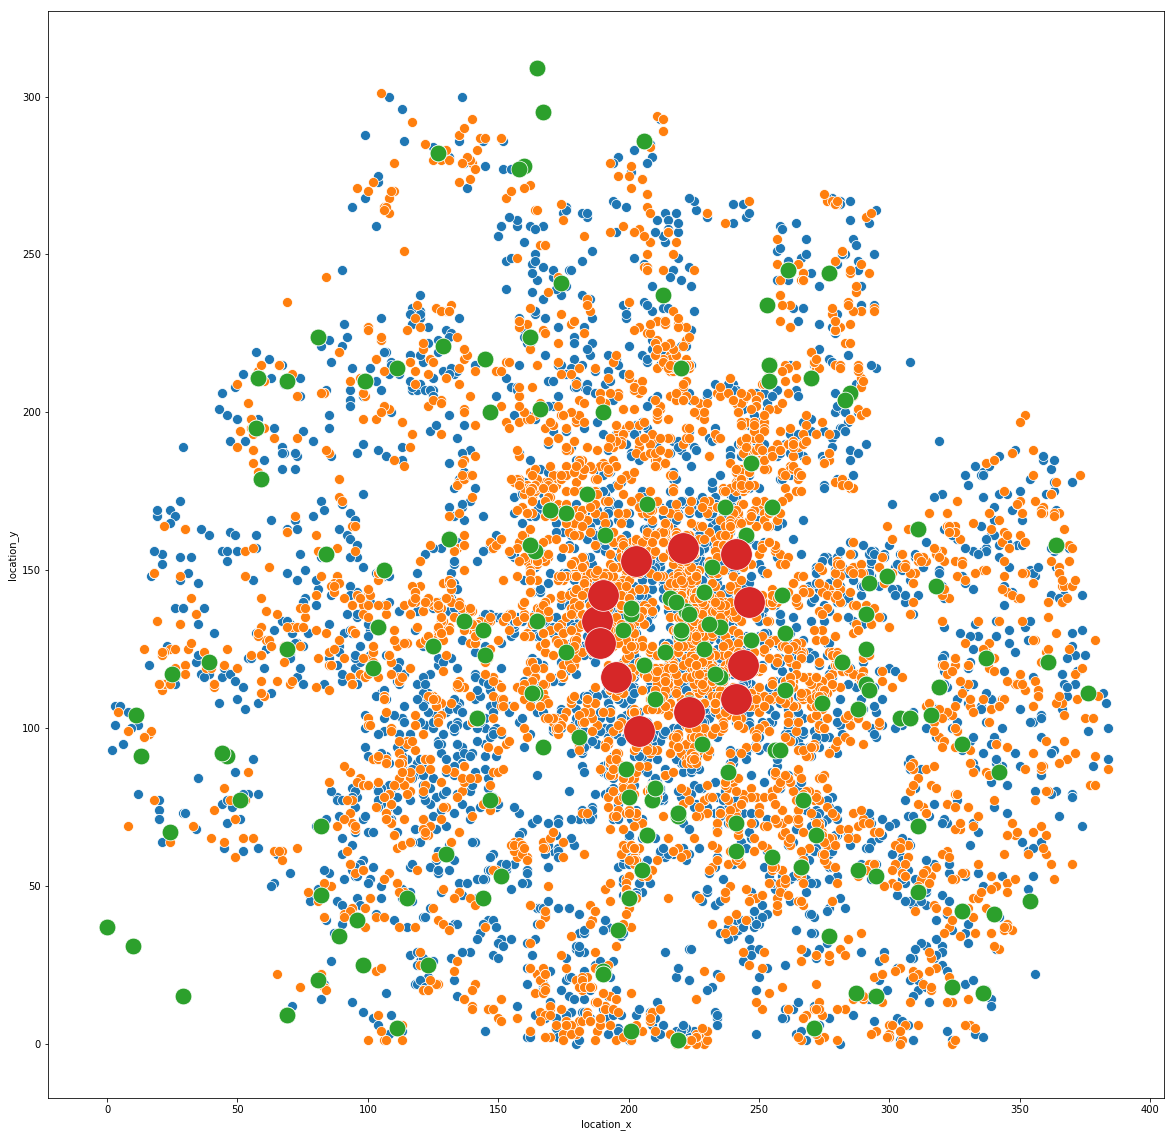

In [379]:
import seaborn as sns
from matplotlib import pyplot
#Where couriers are located

a4_dims = (20, 20)
#df = mylib.load_data()
fig, ax = pyplot.subplots(figsize=a4_dims)

#Where dropOFF places are located
sns.scatterplot(x=orders['dropoff_location_x'], y=orders['dropoff_location_y'], ax = ax, s = 100,markers='|');

#Where pickUP places are located
sns.scatterplot(x=orders['pickup_location_x'], y=orders['pickup_location_y'], ax = ax, s = 100);

#Coriers
sns.scatterplot(x=couriers['location_x'], y=couriers['location_y'], ax = ax, s = 280);

#Depots
sns.scatterplot(x=depots['location_x'], y=depots['location_y'], ax = ax, s = 1000);

In [369]:
MAPLISTS = []
for el in range(len(couriers.courier_id)):
    MAPLISTS.append([couriers.courier_id[el]])

### Integration of TSP for on courier

In [370]:
### func block
def pay(x0,x1,y0,y1,data1):
    if (len(data1[(data1['pickup_location_x'] == x0) & 
                  (data1['pickup_location_y'] == y0) &
                  (data1['dropoff_location_x'] == x1) &
                  (data1['dropoff_location_y'] == y1)]) != 0):
        index = data1[(data1['pickup_location_x'] == x0) & 
                  (data1['pickup_location_y'] == y0) &
                  (data1['dropoff_location_x'] == x1) &
                  (data1['dropoff_location_y'] == y1)].index.values.astype(int)
        payment = data1.iloc[index]['payment']
        #print(payment)
    else:
        payment=0
    return(payment)

def TtoSend(x0,x1,y0,y1,data1,sign):
    travel_minutes = 10 + (abs(x0 - x1) + abs(y0 - y1))
    WELLNES = (-pay(x0,x1,y0,y1,data1) + travel_minutes*2)*sign
    ##########Если че надо добавить условия, чтобы пропускать WELLNES >0 | Made in preprocessing
    #orders['timeInMove']
    #orders['pickup_to'] orders['pickup_from'] orders['dropoff_to'] orders['dropoff_from']
    return(WELLNES)

def compute_time_matrix(locations,data1,sign):
    timesM = {}
    for from_counter, from_node in enumerate(locations):
        timesM[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                timesM[from_counter][to_counter] = 0
            else:
                # Time~Distance
                timesM[from_counter][to_counter] =TtoSend(from_node[0],to_node[0],from_node[1],to_node[1],data1,sign)
    
    return(timesM)

def time_callback(from_index, to_index):
    """Returns the time between the two nodes."""
    # Convert from routing variable Index to TIMES matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return(time_matrix[from_node][to_node])
def print_solution(manager, routing, assignment,sign1):
    """Prints assignment on console."""
    sign = sign1*(-1)
    SUMMARY = sign*(assignment.ObjectiveValue())
    sorted_path =[]
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        sorted_path.append(tempMas[index])
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    #print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)
    #print(sorted_path)
    #print(SUMMARY)
    return(sorted_path,SUMMARY)

def workHard(tempMas,orders,sign):
    manager = pywrapcp.RoutingIndexManager(len(tempMas),1, 0)# Could Be estimated BY TIME PREPROCESSING OR LEN(ORDERS)
    routing = pywrapcp.RoutingModel(manager)
    time_matrix = compute_time_matrix(tempMas,orders,sign)# 1 for to Entry,-1 for to Drop

#Code below could or have to be changed for Better Perfomance
    transit_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.time_limit.seconds = 30
    assignment = routing.SolveWithParameters(search_parameters)
    sorted_path,SUMMARY = print_solution(manager, routing, assignment,1)
    pId = list(np.array(sorted_path[1:])[:,2])
    return(sorted_path,SUMMARY,pId)

#### Просчет матрицы

In [371]:
start_cords=[]
end_cords=[]
print(len(orders))
for i in range(len(orders)):
    start_cords.append([orders['pickup_location_x'][i],orders['pickup_location_y'][i],orders['pickup_point_id'][i]])
    end_cords.append([orders['dropoff_location_x'][i],orders['dropoff_location_y'][i],orders['dropoff_point_id'][i]])

5444


In [ ]:
ac = 0
sign = 9
courier = {}
SUMMA =0
A=20
MAPLISTN = MAPLISTS.copy()
for CUR in MAPLISTS:
    id = CUR[0]
    Ccords=[int(couriers[couriers['courier_id']==id]['location_x']),int(couriers[couriers['courier_id']==id]['location_y'])]
    ##ALGO FOR WINDOWS -> numb & start_cords
    tempMas = [Ccords]+start_cords[:A]#Has to be changed
    ac = 'pickup'
    sign = 1
    #pId=orders[orders['order_id'] == ors]['pickup_point_id']
    sorted_path, SUMMARY,pId = workHard(tempMas, orders, sign)
    SUMMA =SUMMA+ SUMMARY
    ors = pId
    courier.update({'courier_id': id, 'action': ac, 'order_id': ors, 'point_id': pId})
    ac = 'dropoff'
    sign = -1
    tempMas = [[int(sorted_path[-1][0]),int(sorted_path[-1][1])]]+end_cords[:A]
    sorted_path, SUMMARY,pId = workHard(tempMas, orders, sign)
    SUMMA =SUMMA+ SUMMARY
    courier.update({'courier_id': id, 'action': ac, 'order_id': ors, 'point_id': pId})
    MAPLISTN[CUR[0]].append(courier)
    print(id)
print(abs(SUMMA))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


In [ ]:
#MAPLISTS[2]

In [ ]:
ac = 0
sign = 9
courier = {}
SUMMA =0
A=20
t=360
MAPLISTN = MAPLISTS.copy()
for CUR in MAPLISTS:
    id = CUR[0]
    Ccords=[int(couriers[couriers['courier_id']==id]['location_x']),int(couriers[couriers['courier_id']==id]['location_y']),t]
    ##ALGO FOR WINDOWS -> numb & start_cords
    start_coords,A,t = timeGoesOn(Ccords,orders,t,Z)
    tempMas = [Ccords]+start_cords[:A]#Has to be changed
    ac = 'pickup'
    sign = 1
    #pId=orders[orders['order_id'] == ors]['pickup_point_id']
    sorted_path, SUMMARY,pId = workHard(tempMas, orders, sign)
    SUMMA =SUMMA+ SUMMARY
    ors = pId
    courier.update({'courier_id': id, 'action': ac, 'order_id': ors, 'point_id': pId})
    ac = 'dropoff'
    sign = -1
    end_cords,A,t = timeGoesOn(Ccords,orders,t,Z)
    tempMas = [[int(sorted_path[-1][0]),int(sorted_path[-1][1])],t]+end_cords[:A]
    sorted_path, SUMMARY,pId = workHard(tempMas, orders, sign)
    SUMMA =SUMMA+ SUMMARY
    courier.update({'courier_id': id, 'action': ac, 'order_id': ors, 'point_id': pId})
    MAPLISTN[CUR[0]].append(courier)
    print(id)
print(SUMMA)

In [ ]:
# def timeGoesOn(Ccords,orders,t,Z):
#     for (orders[orders['pickup_to']<t] & orders[orders['dropoff_to']<t]).index
    
#         if Z = 0:
#             pass
#         else:

    
#     return(start_coords,A,t)

In [ ]:
# t=360
# (orders[orders['pickup_from']<t] & orders[orders['dropoff_to']<t])